#  Summary
In this research, the issue of attributing cyber attacks to threat actor groups is addressed by making use of event-level data in a structured fashion. The employed data was a synthetic but logically sound dataset, encompassing temporal, technical, and behavioral aspects of cyber attacks. After the validation of data quality and the encoding of categorical variables, a data partition was done based on time to avoid information disclosure. The employed models included baseline models and more sophisticated machine learning algorithms, with Log Loss and F1-score metrics used for analysis. The model stability test was performed by cross-validation; further testing was done on a holdout test of the temporal test set. The findings of the research show that models with the capacity to model complex data uncertainties are better compared to baseline models, especially when handling overlaps of classes. The research has a realistic data framework for attributing cyber attacks, irrespective of it being a completely synthetic dataset.

# 1. Problem Definition

## Context

The **Global Cybersecurity Threats (2015–2024)** dataset gathers digital security incidents across multiple countries and industries.  
Each row describes an attack, including its type, target industry, financial loss, number of affected users, exploited vulnerability, defense mechanism, and resolution time.

The goal of this project is to apply **Data Science techniques** to answer two central business questions:

---

### 1. **Who was the attacker?**

After containing an incident, cybersecurity teams need to estimate **who orchestrated the attack**  
(e.g., Hacker Group, Insider, Nation-state, Unknown).

- **Success Metric**: *Log Loss*, since the real value lies in returning probabilities that support investigation and help prioritize hypotheses.  
- **Auxiliary Metric**: *F1-Macro*, used to evaluate whether the model treats all classes fairly.  
  - This is important because, even when classes are balanced, the model may favor some over others.  
    F1-Macro ensures that we assess the average performance across classes.  
- **Baselines**:  
  - Always predict the majority class (mode).  
  - Predict the empirical class distribution (priors).  

---

### 2. **How long and how much will it take to resolve the incident?** *(Not yet implemented)*

Beyond identifying the attacker, it’s also relevant to predict the **Incident Resolution Time (in hours)**  
and **Financial Loss (in millions of dollars)** as proxies for direct cost.  

- The prediction of **time and cost** has not yet been implemented but will be addressed in future stages.  
  This scenario can be modeled in two ways:  
  - **Multioutput Regression**: a single model predicting time and cost simultaneously.  
  - **Separate Models**: one model for time and another for cost.  

**Regression Success Metrics:**  
- *MAE* (Mean Absolute Error — easy to interpret in hours or millions of dollars).  
- *RMSE* (Root Mean Squared Error — penalizes large errors more heavily).  
- *R²* (explained variance — how much variability is captured by the model).  

# Dataset Overview: Global Cybersecurity Threats (2015–2024)

---

## Data Source
The **“Global Cybersecurity Threats (2015–2024)”** dataset from Kaggle compiles **synthetic cybersecurity incidents** across multiple countries and industry sectors.  
Each row represents a single incident and includes details on the attack type, targeted sector, exploited vulnerabilities, financial losses, affected users, defense mechanisms applied, and time to resolution.

- **Source:** Kaggle  
- **Nature:** Synthetic and balanced, designed for supervised machine learning.  
- **Author Reputation:** High within the Kaggle community (Grandmaster of Datasets).  

---

## Features

| Column Name | Description |
|------------|-------------|
| Country | The country where the incident occurred |
| Year | Year of the incident |
| Threat Type | Type of cybersecurity threat (e.g., Malware, DDoS) |
| Attack Vector | Method of attack (e.g., Phishing, SQL Injection) |
| Target Industry | Targeted industry (Finance, Healthcare, Education, etc.) |
| Number of Affected Users | Number of affected users |
| Financial Loss ($M) | Direct financial loss in millions |
| Severity Level | Risk level: Low, Medium, High, Critical |
| Response Time (Hours) | Time taken to resolve the incident |
| Defense Mechanism Used | Defense mechanism applied post-attack |
| Security Vulnerability Type | Type of exploited vulnerability |
| Attack Source | Target label: Hacker Group, Insider, Nation-state, Unknown |

---

## Data Characteristics
- **Balanced distribution** across attackers, countries, industries, and attack types.  
- **Numerical variables** (financial loss, affected users, response time) are roughly evenly distributed, indicating a synthetic or standardized nature.  
- **Categorical variables** have a moderate number of unique values, suitable for tree-based models without extensive encoding.  
- **Temporal dimension:** `Year` allows for chronological train-test splitting to avoid data leakage.

---

## Data Preparation Steps
1. **Data Cleaning**
   - Checked for duplicates: none found.
   - Checked for missing or invalid values: dataset is complete; no imputation needed.

2. **Feature Selection**
   - Predictive features used: `Country`, `Threat Type`, `Attack Vector`, `Target Industry`, `Number of Affected Users`, `Financial Loss`, `Severity Level`, `Response Time`, `Defense Mechanism Used`, `Security Vulnerability Type`.
   - `Year` used only for chronological splitting, not as a predictive feature.

3. **Encoding / Scaling**
   - No scaling required; tree-based models are insensitive to value magnitude.
   - No one-hot encoding used; categorical features can be represented as integers.

4. **Train-Test Split**
   - Chronological split: first 80% of records (2015–2022) for training, last 20% (2023–2024) for testing.
   - Prevents future information leakage.

5. **Exploratory Analysis and Validation**
   - Checked numerical distributions for patterns and outliers.
   - Checked correlations: low multicollinearity.
   - Analyzed unique values per feature to estimate feature importance.

---

## Reliability and Limitations
- **Source Reliability:** 2 (generally reliable) based on author reputation.  
- **Real-world applicability:** E (low), as numerical distributions do not fully reflect real-world data.  
- **Synthetic nature:** Designed for machine learning purposes; business insights should be interpreted cautiously.



## Problem Statement

> **Scenario:** The incident has already been contained. Now we must support the critical decision of:  
> - Estimating **who was the attacker**, providing probabilities to guide the investigation, allocate efforts,  
>   and inform future improvements to enhance the system’s security.  


# 2. Data Understanding

In [3]:

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import seaborn as sns




## 2.1 Dataset Loading

In this step, we load the raw dataset and inspect its dimensions and first few rows  
to get an initial sense of the data’s granularity and consistency.  


In [4]:
df = pd.read_csv("../data/Global_Cybersecurity_Threats_2015-2024.csv")

print("Size of the dataset:", df.shape)
df.head()

Size of the dataset: (3000, 10)


,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169,Hacker Group,Unpatched Software,VPN,63
1,China,2019,Ransomware,Retail,62.19,295961,Hacker Group,Unpatched Software,Firewall,71
2,India,2017,Man-in-the-Middle,IT,38.65,605895,Hacker Group,Weak Passwords,VPN,20
3,UK,2024,Ransomware,Telecommunications,41.44,659320,Nation-state,Social Engineering,AI-based Detection,7
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682,Insider,Social Engineering,VPN,68


## 2.2 Structure of Variables

Here we assess the data types, the presence of missing values,  
and the initial descriptive statistics.  

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              3000 non-null   object 
 1   Year                                 3000 non-null   int64  
 2   Attack Type                          3000 non-null   object 
 3   Target Industry                      3000 non-null   object 
 4   Financial Loss (in Million $)        3000 non-null   float64
 5   Number of Affected Users             3000 non-null   int64  
 6   Attack Source                        3000 non-null   object 
 7   Security Vulnerability Type          3000 non-null   object 
 8   Defense Mechanism Used               3000 non-null   object 
 9   Incident Resolution Time (in Hours)  3000 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 234.5+ KB


In [6]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Country,3000,10,UK,321,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,3000.0,NaN,NaN,NaN,2019.570333,2.857932,2015.0,2017.0,2020.0,2022.0,2024.0
Attack Type,3000,6,DDoS,531,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Target Industry,3000,7,IT,478,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Financial Loss (in Million $),3000.0,NaN,NaN,NaN,50.49297,28.791415,0.5,25.7575,50.795,75.63,99.99
Number of Affected Users,3000.0,NaN,NaN,NaN,504684.136333,289944.084972,424.0,255805.25,504513.0,758088.5,999635.0
Attack Source,3000,4,Nation-state,794,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Security Vulnerability Type,3000,4,Zero-day,785,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Defense Mechanism Used,3000,5,Antivirus,628,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Incident Resolution Time (in Hours),3000.0,NaN,NaN,NaN,36.476,20.570768,1.0,19.0,37.0,55.0,72.0


In [7]:
df.isnull().sum()

Country                                0
Year                                   0
Attack Type                            0
Target Industry                        0
Financial Loss (in Million $)          0
Number of Affected Users               0
Attack Source                          0
Security Vulnerability Type            0
Defense Mechanism Used                 0
Incident Resolution Time (in Hours)    0
dtype: int64

## 2.3 Duplicates

First, we check for duplicate entries considering all columns.  


In [8]:
print("Complete duplicates:", df.duplicated().sum())


Complete duplicates: 0


## 2.4 Role of the Variable *Defense Mechanism Used*

An initial question in the project was:  
**Does the field `Defense Mechanism Used` represent the defense mechanism that existed before the attack,  
or the one adopted after the attack?**

To investigate this, we checked for **duplicates while ignoring `Defense Mechanism Used`**,  
aiming to identify incidents that are identical in every other aspect but recorded multiple times  
only because the defense mechanism differed.  


In [9]:
df_no_defense = df.drop(columns=["Defense Mechanism Used"])
dup_rows = df_no_defense.duplicated(keep=False).sum()
print("Duplicates ignored, Defense Mechanism Used:", dup_rows)


Duplicates ignored, Defense Mechanism Used: 0


### Results
- **No duplicate records were found when ignoring the defense column.**  
- This suggests that, in the current dataset, each incident was recorded **uniquely**, with only one value for `Defense Mechanism Used`.

### Discussion
In real-world cybersecurity scenarios, it is common for **multiple defense mechanisms to be applied to handle the same attack**  
(for example: *Firewall + VPN + AI-based detection*).  
If the logging system does not allow selecting multiple values, this can lead to data entry issues such as:  
- The same incident being recorded **two or more times**, differing only in the `Defense Mechanism Used` field.  
- Each row representing **a pair (incident, applied defense)** rather than the incident itself.  

Since we did not observe this duplication pattern, we propose two hypotheses:  
1. The dataset was normalized to maintain **a single record per attack**, storing only **the main defense mechanism**.  
2. During data collection, only **the first or most relevant defense applied** was recorded, ignoring multiple combinations.  

### Conclusion
Therefore, we interpret that `Defense Mechanism Used` most likely refers to the **primary defense mechanism chosen after the attack**.  
Nevertheless, we document the risk that this variable may not fully represent the complete set of defensive measures actually used in a real incident.  


## 2.4 Logical Validation of Values

Since variables such as financial loss, number of affected users, and resolution time  
do not make sense with negative or zero values, we validated the dataset for possible inconsistencies.  

In [10]:
num_cols = df.select_dtypes(include="number").columns.tolist()

for col in num_cols:
    invalid_count = (df[col] <= 0).sum()
    if invalid_count > 0:
        print(f"{col}: {invalid_count} valores <= 0")

## Key Variables for Problem 1

- **Country**: will be used.  
  Each country has different contexts in terms of cybersecurity maturity, data protection policies, exposure to hacker groups, and even geopolitical relevance.  
  These factors can influence both the type of attacker and the time required to resolve the incident.  

- **Year**: will **not** be used as a predictive variable.  
  Although relevant for exploratory analysis and temporal train-test splitting, using `Year` as a feature in prediction poses risks:  
  - The dataset only goes up to 2024, meaning the model might learn patterns specific to that period and fail to generalize to future years (e.g., 2025).  
  - The model could capture artificial trends (e.g., “Nation-state increased in 2023”) that may not repeat.  
  - In random KFold validation, `Year` could cause **temporal leakage**, artificially inflating performance metrics.  
  Therefore, `Year` will only be used for historical trend analysis and as a criterion for separating training and testing data, never as a predictive feature.  

- **Attack Type**: will be used.  
  The type of attack (phishing, ransomware, DDoS, etc.) is one of the main indicators of who the attacker was,  
  since different groups tend to use distinct strategies.  
  It may also influence resolution time, as some types are easier to contain than others.  

- **Target Industry**: will be used.  
  Each sector (healthcare, government, finance, education, telecommunications, etc.) has unique vulnerabilities and attractiveness to attackers.  
  For instance, insiders are more common in banks, while nation-states may target education and research institutions.  

- **Financial Loss (in Million $)**: will be used, with caution.  
  This variable represents the financial loss associated with the incident.  
  However, the dataset does not clarify whether it refers to **direct losses** (immediate response costs) or **indirect losses** (subsequent impacts such as lawsuits, customer churn, or reputation damage).  
  In this project, we assume it represents **direct losses**, as they are more objective and easier to estimate.  
  This assumption also simplifies its use as a target in future regression models for cost prediction.  
  Additionally, we can check for correlations with `Number of Affected Users` to explore potential signs of indirect losses.  

- **Number of Affected Users**: will be used.  
  Represents the number of users impacted by the incident.  
  It can indicate both the direct impact (more users → greater damage) and the complexity of resolution time and cost.  
  It may also relate to the attacker’s type: large-scale attacks usually affect more users,  
  while insider threats tend to be more limited in scope.  

- **Security Vulnerability Type**: will be used.  
  Identifies the exploited vulnerability (e.g., outdated software, weak passwords, social engineering).  
  This variable is directly tied to the attacker’s modus operandi and can help distinguish between different groups.  

- **Defense Mechanism Used**: will be used, but with caution.  
  The main uncertainty is whether this field represents the defense mechanism **in place before the attack**  
  or the one **adopted after the incident**.  
  - If it refers to the pre-attack mechanism, it is fully valid as a feature (it reflects the system’s security level).  
  - If it refers to the post-attack mechanism, it could cause **data leakage** (using future information to predict the past).  
  Based on our prior analysis, we assume it represents the mechanism chosen to handle the situation after detection.  
  In that case, it remains valid, since in real-world scenarios this information would be available immediately after containment  
  and could support the ongoing investigation.  

- **Incident Resolution Time (in Hours)**: will be used.  
  Represents the time required to resolve the incident.  
  Predicting this variable is useful for estimating SLAs, response costs, and team allocation.  

---

## Prediction Target and Evaluation Metrics

- **Attack Source**: classification target.  
  This is the variable we aim to predict in order to identify who orchestrated the attack  
  (Hacker Group, Insider, Nation-state, or Unknown).  
  The prediction should be probabilistic, to assist investigation and prioritization.  
  - **Primary Metric**: Log Loss (measures the quality of predicted probabilities).  
  - **Secondary Metric**: F1-Macro, to ensure the model maintains balanced performance across all classes,  
    avoiding favoritism toward specific categories.  


# 3. Train–Test Split Strategy

In Data Science projects, it is essential that **test data** be treated as if it were **completely new data in production**.  
This means that:

- The test set **must not influence any modeling decision**, whether during preprocessing, exploratory analysis, or feature selection.  
- It should be used **only once, at the very end**, to evaluate the model’s true performance in a scenario that simulates unseen data.

In our case, the dataset contains the temporal variable **`Year`**, which allows us to apply a **temporal split**.  
This strategy is more appropriate than a random split because:

1. It **respects the chronological order of events**, simulating a realistic setting — training the model on past data and testing on future data.  
2. It prevents **information leakage**, since future attacks could not have been known during training.  
3. It creates a more production-like environment, where the model is challenged to generalize to attack patterns that have not yet appeared in the historical data.

### Methodology Adopted
- The data were **sorted by year in ascending order**.  
- We defined **the first 80% of records** as the **training set** and the **last 20%** as the **test set**.  
- The training set was used for **exploration, preparation, and model development**, while the test set was kept isolated, serving exclusively for **final evaluation**.  

This approach ensures a fairer assessment of the model’s generalization ability in a real-world cybersecurity environment,  
where future incidents may present **new patterns, combinations of vulnerabilities, and defense mechanisms**.  


In [11]:

df_sorted = df.sort_values(by="Year").reset_index(drop=True)

split_index = int(len(df_sorted) * 0.8)

train_df = df_sorted.iloc[:split_index]
test_df  = df_sorted.iloc[split_index:]

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

print("\nMinimum and maximum year (Training):", train_df["Year"].min(), "-", train_df["Year"].max())
print("Minimum and maximum year (Test):", test_df["Year"].min(), "-", test_df["Year"].max())
df = train_df

Train shape: (2400, 10)
Test shape: (600, 10)

Minimum and maximum year (Training): 2015 - 2023
Minimum and maximum year (Test): 2023 - 2024


# 4. Exploratory Data Analysis (EDA)

After separating the data into training and test sets, we conducted the **Exploratory Data Analysis (EDA)** exclusively on the **training set**, ensuring that no information from the test set influences our modeling decisions.

The purpose of the EDA is to gain a deeper understanding of the available data, identify patterns, relationships among variables, and detect potential issues.  

### 4.1 Descriptive Statistics with Formatting

In this step, we use `df.describe()` with visual formatting to analyze the distribution of numerical variables.  
The goal is to highlight **means, dispersion (standard deviation)**, and **median**, making it easier to compare variables across different scales.  

In [12]:
df.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Year,2400.000000,2018.588333,2.307470,2015.000000,2017.000000,2019.000000,2021.000000,2023.000000
Financial Loss (in Million $),2400.000000,50.262667,28.848126,0.500000,25.632500,50.150000,75.640000,99.990000
Number of Affected Users,2400.000000,506040.062917,290206.131490,424.000000,257159.500000,510882.500000,761286.500000,999545.000000
Incident Resolution Time (in Hours),2400.000000,36.473333,20.682844,1.000000,19.000000,37.000000,55.000000,72.000000


### Interpretation

- **Year**: shows little variation (2015 to 2023), serving mainly as a temporal reference.  
- **Financial Loss (in Million $)**: ranges from ~0.5 to ~100 million, with an average of ~50.  
- **Number of Affected Users**: ranges from hundreds to nearly 1 million, with an average of ~500k.  
- **Incident Resolution Time (in Hours)**: ranges from 1 to 72 hours, with an average of ~36h.  

➡️ We observe a **large difference in scale among variables** — values range from tens (hours) to hundreds of thousands (users).  

This means that, if we use **models sensitive to feature scaling** (such as Logistic Regression, KNN, or Neural Networks), it will be **essential to apply normalization or standardization**.  
On the other hand, **tree-based models** (Random Forest, XGBoost, LightGBM) are not affected by monotonic transformations, since they preserve the order of observations.  


## 4.2 Univariate Analysis

### 4.2.1 Target Analysis

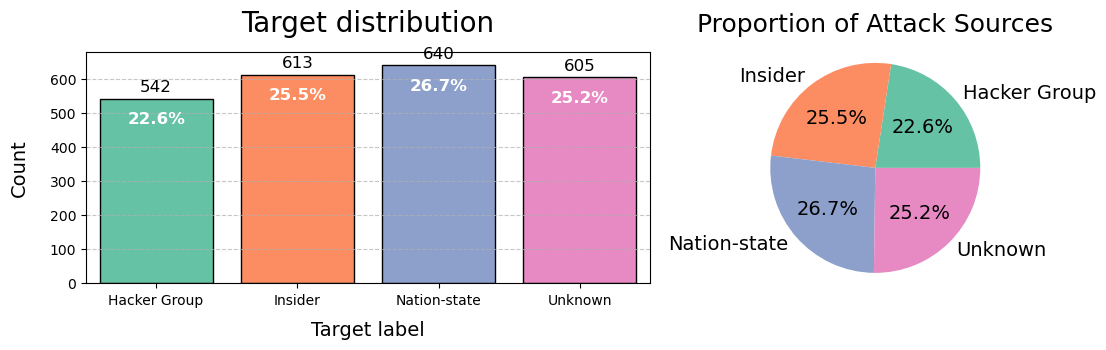

In [13]:
colors = sns.color_palette("Set2", n_colors=df['Attack Source'].nunique())

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 3), gridspec_kw={'width_ratios': [2, 1]})

attack_counts = df['Attack Source'].value_counts().sort_index()

bars = axs[0].bar(
    attack_counts.index,
    attack_counts.values,
    color=colors,
    edgecolor="black"
)
axs[0].set_title("Target distribution", fontsize=20, pad=15)
axs[0].set_ylabel("Count", fontsize=14, labelpad=15)
axs[0].set_xlabel("Target label", fontsize=14, labelpad=10)

axs[0].bar_label(bars, labels=attack_counts.values, padding=3, fontsize=12)
axs[0].bar_label(
    bars,
    labels=[f"{(x/attack_counts.sum())*100:2.1f}%" for x in attack_counts.values],
    padding=-20,
    fontsize=12,
    color="white",
    weight="bold"
)

axs[0].margins(0.025, 0.06)
axs[0].grid(axis="y", linestyle="--", alpha=0.7)

axs[1].pie(
    attack_counts.values,
    labels=attack_counts.index,
    colors=colors,
    autopct="%1.1f%%",
    textprops={"fontsize": 14}
)
axs[1].set_title("Proportion of Attack Sources", fontsize=18, pad=15)
axs[1].axis("equal")

plt.show()

### Discussion: How to Handle the *Unknown* Class in `Attack Source`

A critical modeling decision is how to treat the **Unknown** class in our target variable (`Attack Source`).  
In practice, incidents without clear attribution are common in cybersecurity, but we need to evaluate whether this category should remain in the model.

### Treatment Options

1. **Keep it as a valid class**  
   - Reflects reality: many attacks truly remain unattributed.  
   - The model learns to recognize patterns that suggest an unidentified attack.  
   - Useful when the goal is **operational realism** (accepting that some attacks will never be attributed).  

2. **Remove the Unknown class**  
   - The model focuses only on known attackers (Insider, Hacker Group, Nation-state).  
   - Advantage: cleaner interpretability.  
   - Disadvantage: loss of data and potential information that could indicate uncertainty.  
   - Useful when the goal is **clear explainability**.  

3. **Treat Unknown as “other”**  
   - Reclassify Unknown as a generic “outlier/anomaly” category.  
   - Useful in a **preventive security** context, to identify attacks that fall outside traditional profiles.  

4. **Semi-supervised approach**  
   - Use Unknown as a partial label.  
   - Example: predict probabilities for each class and, if none exceed a certain *threshold*, assign Unknown.  
   - Useful when we prefer the system to say **“I don’t know”** rather than make a gross misclassification.  

---

### Decision for This Project
For this Kaggle study, we will **keep Unknown as a class in the first version of the model**, ensuring a more realistic baseline.  
Subsequently, we can compare two scenarios:  

- **Model A:** including Unknown as a class.  
- **Model B:** excluding Unknown.  

This comparison will allow us to measure how the presence of Unknown affects classification metrics (e.g., F1-Macro and Log Loss).  


### 4.2.2 Analysis of Continuous Variables

In this section, we explore the main continuous variables to understand their distributions,  
identify potential outliers, and detect patterns that might influence model behavior.  

Typical analyses include:

- **Histograms and density plots** to assess the overall shape of distributions (e.g., symmetry, skewness, heavy tails).  
- **Boxplots** to visualize dispersion and identify extreme values.  
- **Correlation matrix** to check relationships between numeric features and potential multicollinearity.  

This step helps determine whether transformations such as logarithmic scaling or normalization  
are necessary to stabilize variance and improve model performance.  


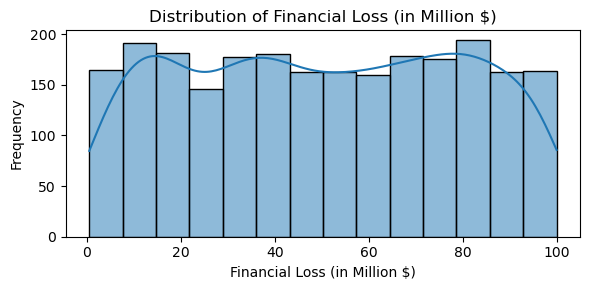

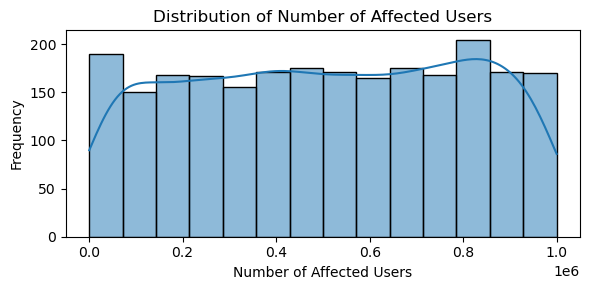

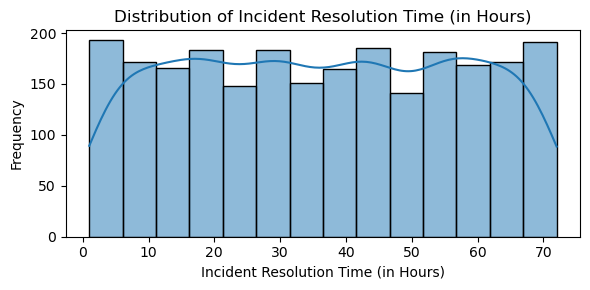

In [14]:

numeric_cols = ['Financial Loss (in Million $)', 'Number of Affected Users', 'Incident Resolution Time (in Hours)']

for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

## Discussion on Numerical Distributions

When analyzing the distributions of **Financial Loss (in Million $)**, **Number of Affected Users**, and **Incident Resolution Time (in Hours)**, several points stand out:

### Observations

1. **Financial Loss (in Million $)**
   - The variable shows an **almost uniform** distribution across the range.  
   - This behavior is unusual for financial data, which typically follow skewed distributions — many small losses and a few very large ones.  
   - This suggests the values were likely **normalized, discretized, or simulated**.

2. **Number of Affected Users**
   - Also displays a **near-uniform** distribution, with no strong concentration in lower or higher values.  
   - In real-world scenarios, most incidents would affect **few users**, while only a few would reach millions.  
   - Once again, this pattern reinforces the hypothesis of **synthetic or artificially balanced** data.

3. **Incident Resolution Time (in Hours)**
   - The distribution is quite homogeneous between 0 and 70 hours.  
   - In real data, resolution time tends to follow something closer to a **log-normal** distribution (many incidents resolved quickly, a few taking much longer).  
   - The uniform behavior suggests standardization or synthetic generation.

---

### Implications
- The analyzed distributions **do not reflect typical patterns of real-world incidents**.  
- On the positive side, there is no strong imbalance, which facilitates supervised modeling.  
- On the negative side, the **low practical representativeness** requires caution when drawing business insights.

---

### Data Origin
Upon further investigation, we found that the dataset is indeed **synthetic**.  
The author claims it was **generated based on real data**, but given the homogeneous distributions observed, this statement appears **questionable**.  

On the other hand:  
- The author has a **strong reputation in the Kaggle community**, being a *Grandmaster of Datasets*.  
- This lends credibility, although not absolute trustworthiness.

---

### Reliability Assessment

The source and information were evaluated using a standard reliability scale (1–6 for source credibility, A–F for information plausibility).

**Source Credibility:** The dataset or author was assigned a rating of 2 (Usually reliable), reflecting a generally positive track record and prior contributions in the field.

**Information Plausibility:** The data distributions received a rating of E (Unlikely), indicating that certain patterns observed are inconsistent with expectations for real-world cybersecurity incidents.

**Overall Classification:** 2E, indicating a generally reliable source, but with information that exhibits low plausibility and should be interpreted cautiously.



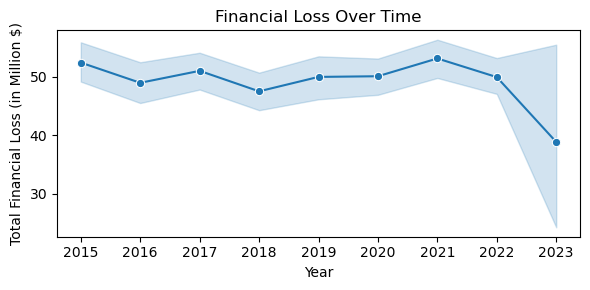

In [15]:
plt.figure(figsize=(6, 3))
sns.lineplot(data=df, x='Year', y='Financial Loss (in Million $)', marker='o')
plt.xlabel("Year")
plt.ylabel("Total Financial Loss (in Million $)")
plt.title("Financial Loss Over Time")
plt.tight_layout()
plt.show()

The reduction observed in 2023 is expected, since part of these records was allocated to the test set.  
Therefore, the volume presented in the training data does not represent the full amount of data available for that year.  


### 4.2.3 Analysis of categorical variables

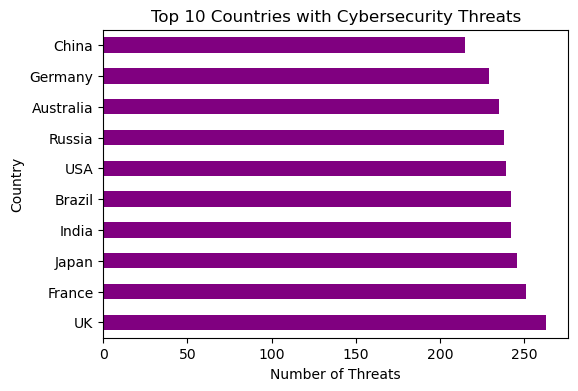

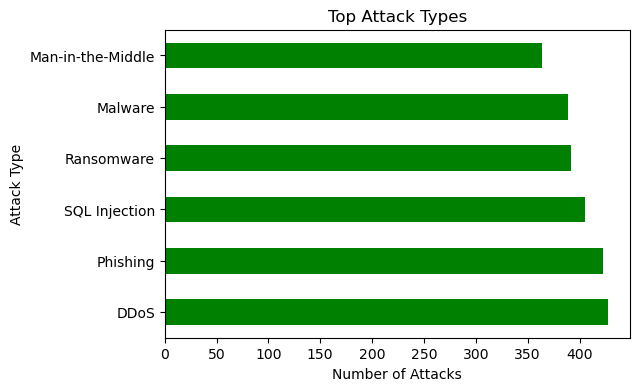

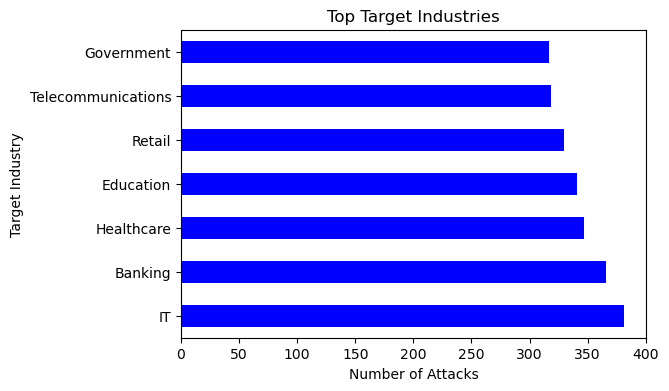

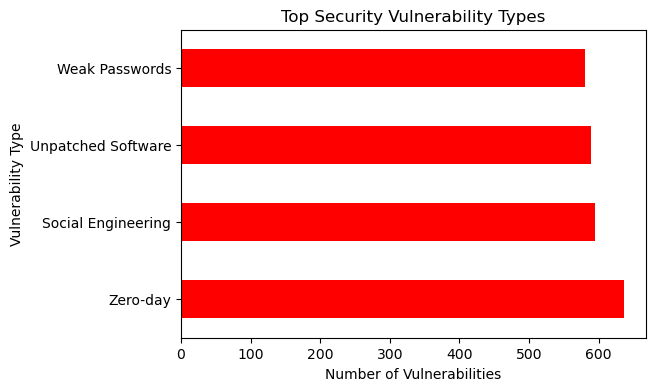

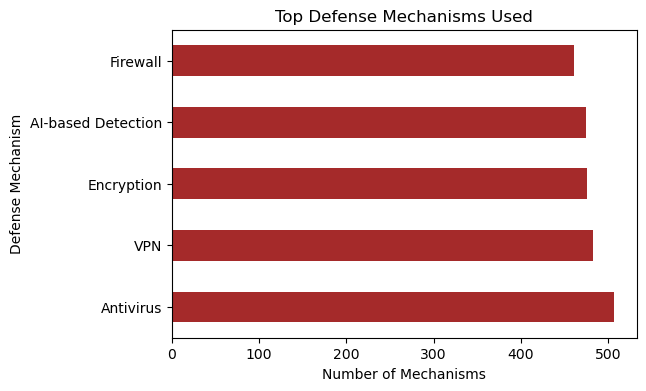

In [16]:

df["Country"].value_counts().head(10).plot(kind = "barh", figsize = (6, 4), color = "purple")
plt.title("Top 10 Countries with Cybersecurity Threats")
plt.xlabel("Number of Threats")
plt.ylabel("Country")
plt.show()

df["Attack Type"].value_counts().plot(kind = "barh", figsize = (6, 4), color = "green")
plt.title("Top Attack Types")
plt.xlabel("Number of Attacks")
plt.ylabel("Attack Type")
plt.show()

df["Target Industry"].value_counts().plot(kind = "barh", figsize = (6, 4), color = "blue")
plt.title("Top Target Industries")
plt.xlabel("Number of Attacks")
plt.ylabel("Target Industry")
plt.show()


df["Security Vulnerability Type"].value_counts().plot(kind = "barh", figsize = (6, 4), color = "red")
plt.title("Top Security Vulnerability Types")
plt.xlabel("Number of Vulnerabilities")
plt.ylabel("Vulnerability Type")
plt.show()

df["Defense Mechanism Used"].value_counts().plot(kind = "barh", figsize = (6, 4), color = "brown")
plt.title("Top Defense Mechanisms Used")
plt.xlabel("Number of Mechanisms")
plt.ylabel("Defense Mechanism")
plt.show()

The charts confirm the hypothesis that the dataset was **intentionally balanced**, ensuring similar representation across countries, industries, attackers, and attack types.  
This is useful for machine learning purposes (it prevents severe class imbalance),  
but it limits the ability to extract realistic insights about the actual global distribution of cyberattacks.  


### 4.3 Bivariate Analysis

In [17]:

df_country_loss = df.groupby('Country')['Financial Loss (in Million $)'].sum().reset_index()

fig = px.choropleth(
    df_country_loss,
    locations='Country',
    locationmode='country names',
    color='Financial Loss (in Million $)',
    color_continuous_scale='Inferno',
    title="Total Financial Loss by Country"
)

fig.show()

C:\Users\Sanasys\AppData\Local\Temp\ipykernel_12368\637934631.py:3: DeprecationWarning: The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.
  fig = px.choropleth(


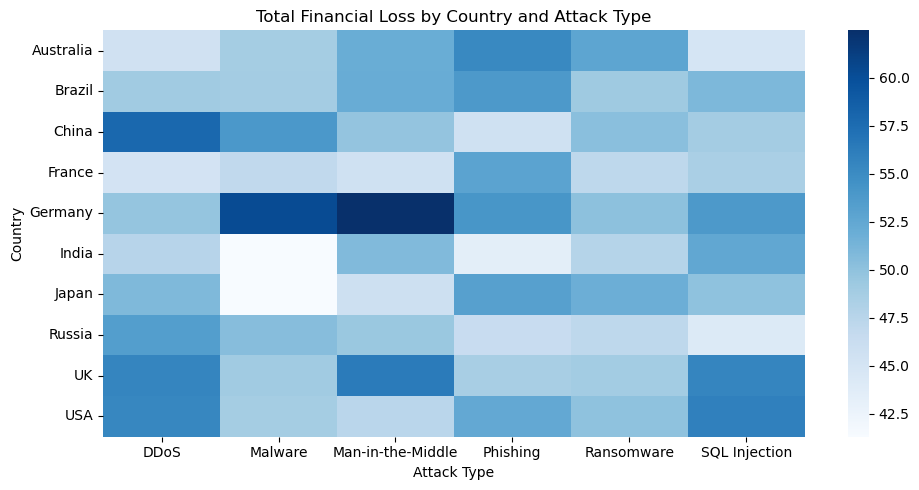

In [18]:

pivot_table = df.pivot_table(index='Country', columns='Attack Type', values='Financial Loss (in Million $)')

plt.figure(figsize=(10, 5))
sns.heatmap(pivot_table, cmap='Blues')
plt.xlabel("Attack Type")
plt.ylabel("Country")
plt.title("Total Financial Loss by Country and Attack Type")
plt.tight_layout()
plt.show()

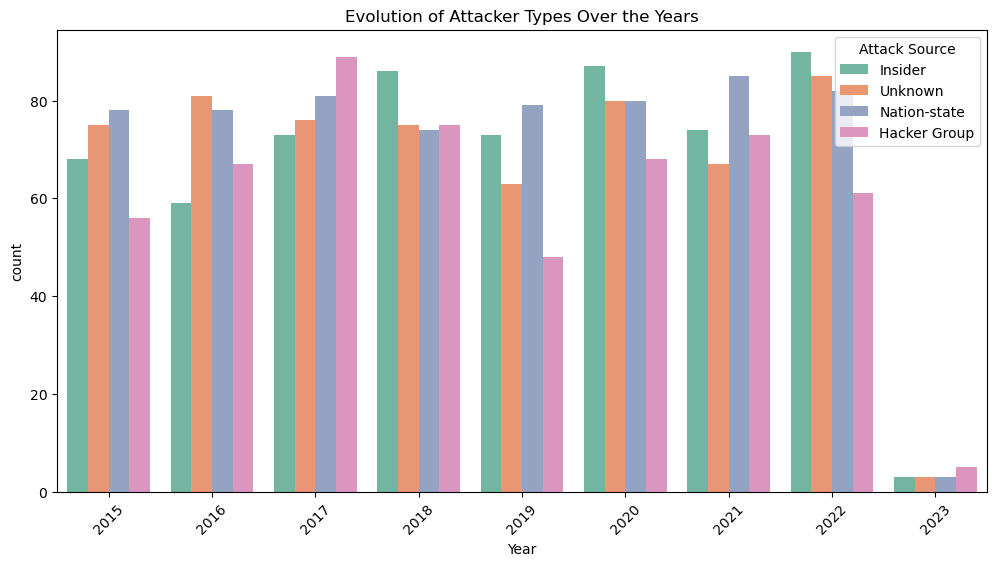

In [19]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.countplot(data=df, x="Year", hue="Attack Source", palette="Set2")
plt.title("Evolution of Attacker Types Over the Years")
plt.xticks(rotation=45)
plt.show()


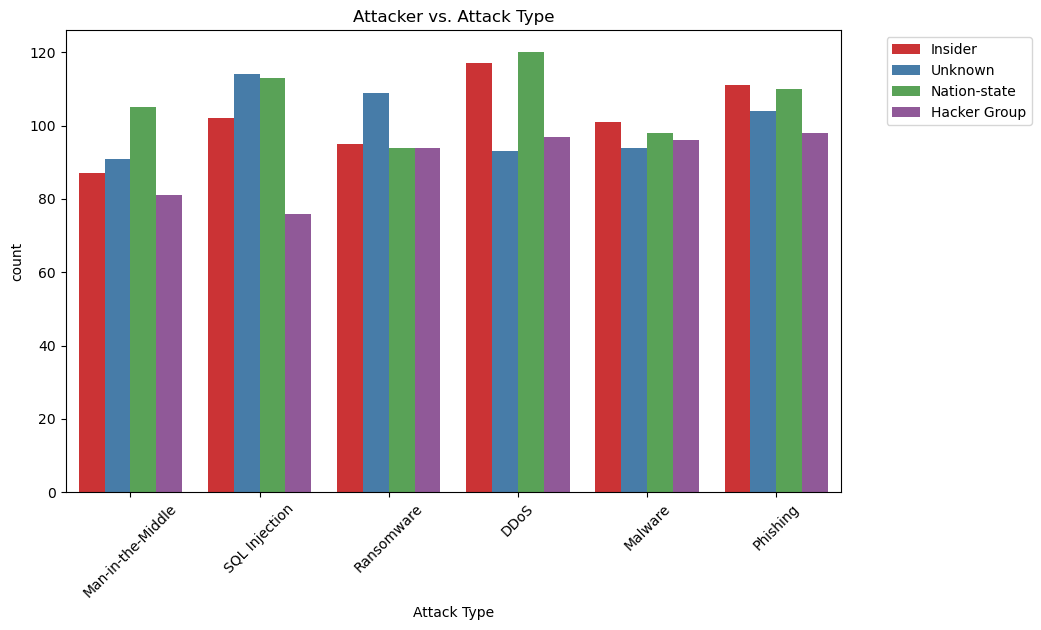

In [20]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="Attack Type", hue="Attack Source", palette="Set1")
plt.title("Attacker vs. Attack Type")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


C:\Users\Sanasys\AppData\Local\Temp\ipykernel_12368\1306606776.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




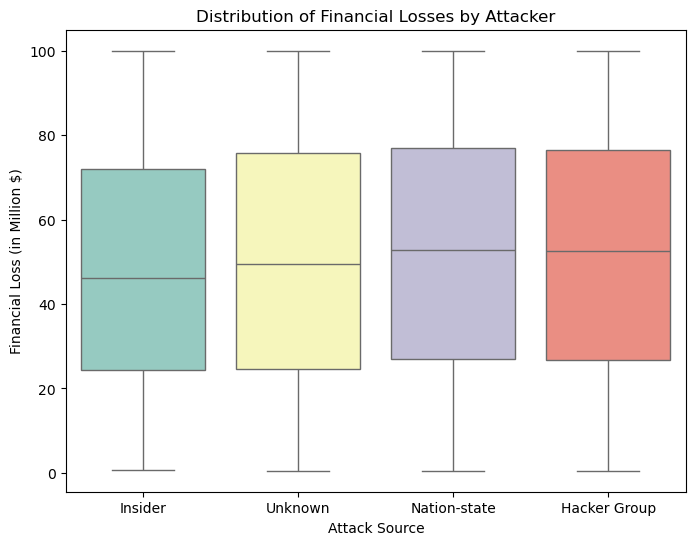

In [21]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="Attack Source", y="Financial Loss (in Million $)", palette="Set3")
plt.title("Distribution of Financial Losses by Attacker")
plt.show()


C:\Users\Sanasys\AppData\Local\Temp\ipykernel_12368\3820185834.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




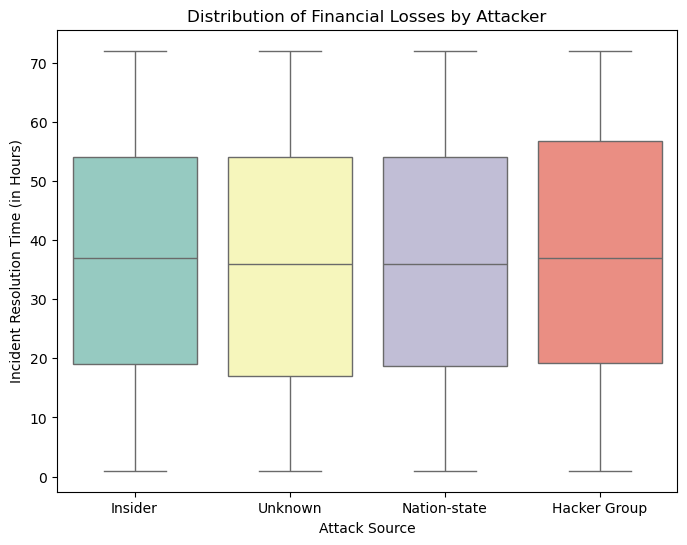

In [22]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="Attack Source", y="Incident Resolution Time (in Hours)", palette="Set3")
plt.title("Distribution of Financial Losses by Attacker")
plt.show()


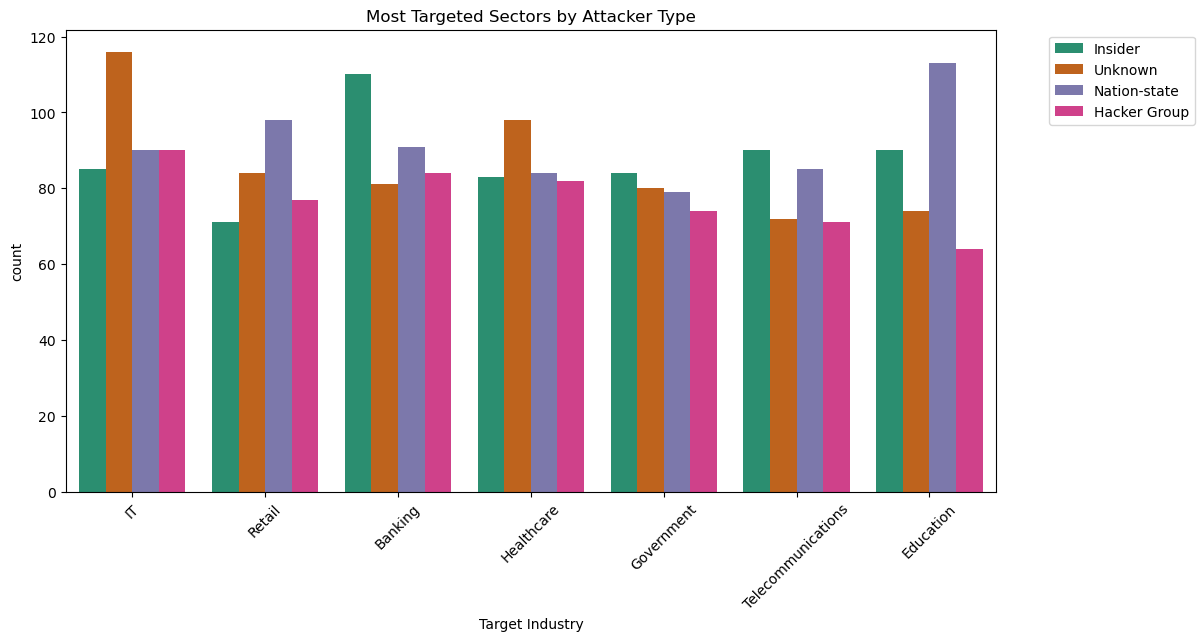

In [23]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x="Target Industry", hue="Attack Source", palette="Dark2")
plt.title("Most Targeted Sectors by Attacker Type")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Comment on the Bivariate Analysis

The bivariate analysis did not reveal any new patterns or strong relationships between variables.  
What we observe is exactly what was expected: a **well-distributed and balanced dataset**, resulting from its **synthetic nature**.  

This behavior reinforces that the associations between variables were intentionally smoothed,  
so that no single predictor would dominate.  
Therefore, the modeling challenge lies not in simple correlations, but in capturing **complex combinations** of variables to distinguish between attackers.  


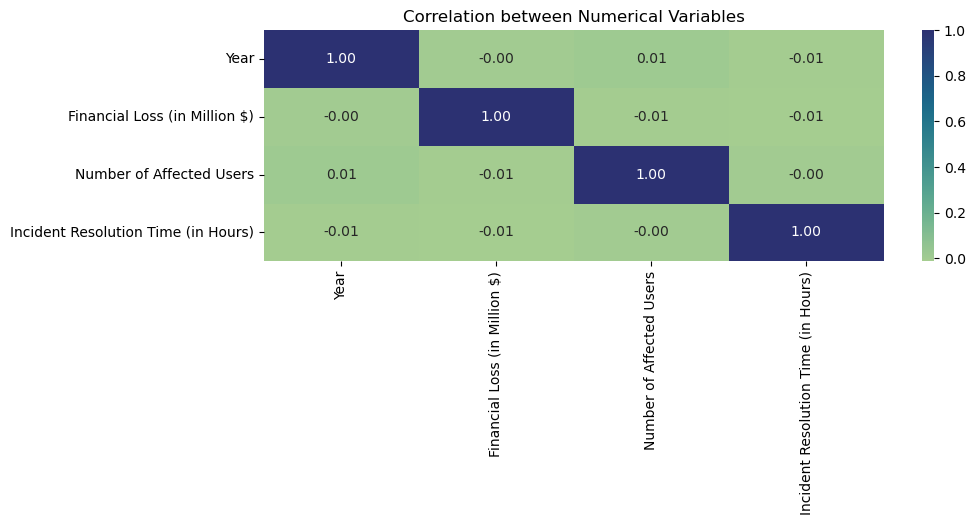

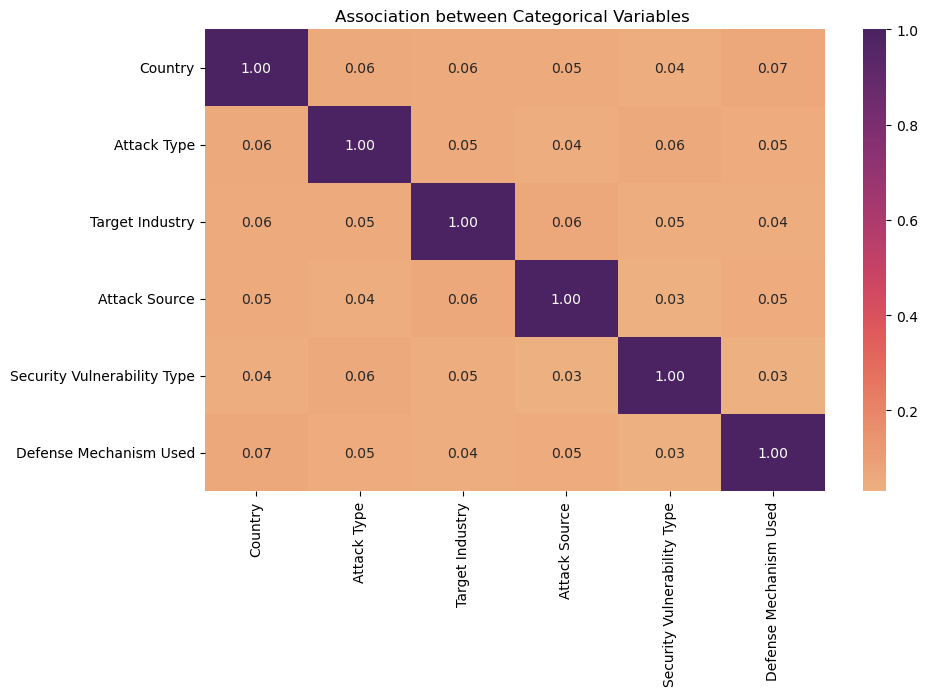

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

num_cols = df.select_dtypes(include='number').columns

corr_num = df[num_cols].corr(method="pearson")

plt.figure(figsize=(10, 3))
sns.heatmap(corr_num, annot=True, cmap="crest", fmt=".2f")
plt.title("Correlation between Numerical Variables")
plt.show()


def categorical_association(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

cat_cols = df.select_dtypes(include='object').columns

cramer_matrix = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))),
    index=cat_cols,
    columns=cat_cols
)

for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 != col2:
            cramer_matrix.loc[col1, col2] = categorical_association(df[col1], df[col2])
        else:
            cramer_matrix.loc[col1, col2] = 1.0

plt.figure(figsize=(10, 6))
sns.heatmap(cramer_matrix, annot=True, cmap="flare", fmt=".2f")
plt.title("Association between Categorical Variables ")
plt.show()


### Interpretation of Correlations and Variable Independence

The correlation analysis confirmed that the dataset **does not show strong collinearity** among variables.  
This has several important implications for modeling:

- **Absence of strong collinearity**  
  → Techniques such as PCA or redundant feature removal are not required.  
  → We can retain almost all variables without a significant risk of informational overlap.  

- **Independent variables**  
  → Each variable carries its own information, contributing in different regions of the decision space.  
  → This diversity tends to enrich the model’s ability to capture subtle patterns.  

- **Challenging classification problem**  
  → Since there are no high correlations, attackers cannot be easily distinguished by a single variable.  
  → Separation must occur through **complex combinations of attributes**, which favors algorithms such as **Random Forest** and **XGBoost**, capable of capturing nonlinear interactions.  

- **Future feature importance**  
  → No variable stood out statistically during this exploratory phase.  
  → The analysis of *feature importance* (via information gain, *permutation importance*, or SHAP values) will be essential to reveal which variables truly help distinguish attackers in practice.  

**Summary:** Although synthetic, the dataset was designed to create a genuine classification challenge — there are no “easy shortcuts” through simple correlations, requiring more sophisticated models to capture the complex relationships among variables.  


## 4.3 Feature Cardinality

An important aspect when evaluating variables is their **cardinality**, meaning the number of distinct values within each feature.  
This analysis is particularly relevant when using tree-based models and later performing interpretation through *feature importance*.  


C:\Users\Sanasys\AppData\Local\Temp\ipykernel_12368\289917304.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




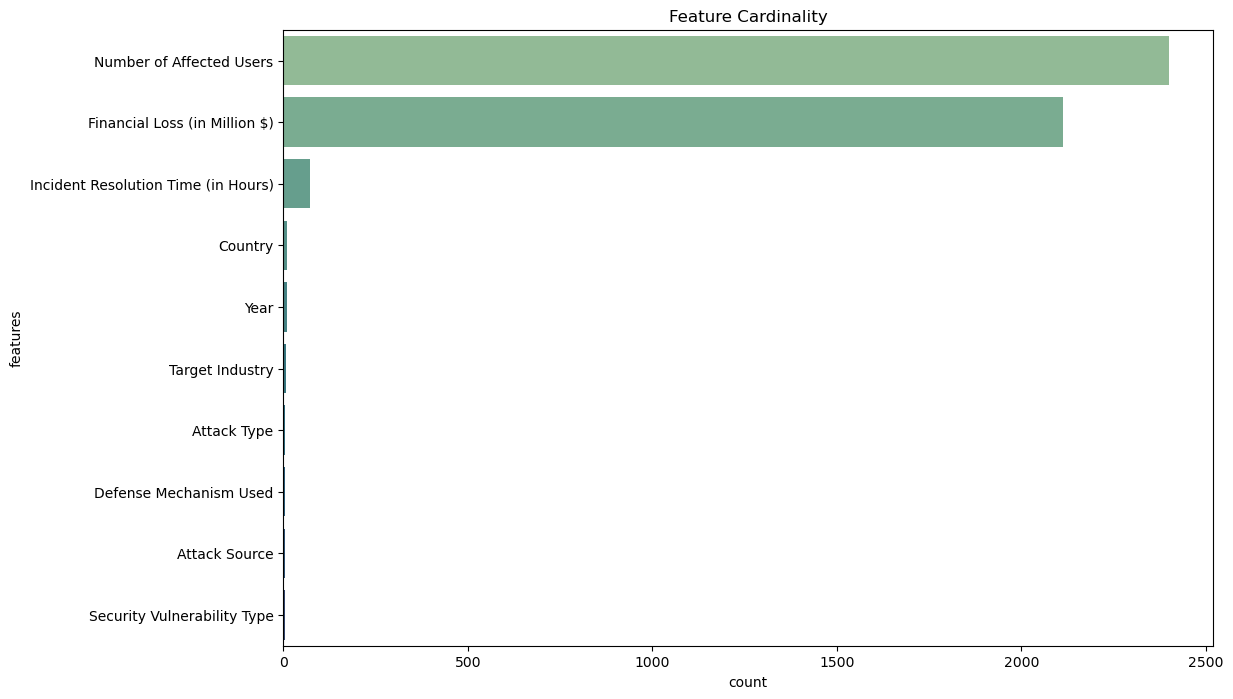

In [25]:

unique_df = pd.DataFrame(df.nunique()).reset_index()
unique_df.columns = ['features', 'count']

unique_df = unique_df.sort_values(by="count", ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(
    y="features", x="count",
    data=unique_df,
    palette="crest", orient='h', ax=ax
)

ax.set_title("Feature Cardinality")
plt.show()


High-cardinality variables can artificially appear more important in tree-based models.  
- **Continuous features** and **categorical features with many levels** tend to show higher importance values even if they are not truly more predictive.  
- This occurs because these variables provide more opportunities to create favorable *splits* by chance during training.  

In this dataset, variables like **`Number of Affected Users`** and **`Financial Loss (in Million $)`** may therefore have inflated importance scores.  

When evaluating feature importance, it is recommended to use robust methods, such as:  
- **Permutation Importance**, which measures the performance drop when a variable is shuffled.  
- **SHAP values**, which assess the marginal contribution of each feature to the prediction.


# 4. Methodology

## 4.1 Overview

The approach of this project follows a structured **supervised learning workflow**:

1. **Problem Definition**: 
   - Classification task: predicting the **Attack Source** (Hacker Group, Insider, Nation-state, Unknown).  
   - Regression task: predicting **Incident Resolution Time (Hours)** and **Financial Loss ($M)**.  
   - This study focuses primarily on the classification task, with regression planned for future iterations.

2. **Data Preprocessing**:  
   - **Missing Values:** None detected; no imputation required.  
   - **Invalid Values:** No negative or zero values in numeric features.  
   - **Categorical Variables:** Encoded as integers; one-hot encoding skipped because **tree-based models** are used.  
   - **Feature Scaling:** Not applied; tree algorithms are insensitive to monotonic transformations.  
   - **Train-Test Split:** Temporal split based on `Year`, with 80% of earlier years for training and 20% later years for testing.

3. **Exploratory Data Analysis (EDA):**  
   - **Univariate Analysis:** Descriptive statistics, histograms, boxplots for numeric features; bar plots for categorical features.  
   - **Bivariate Analysis:** Correlations, heatmaps, count plots to assess relationships between features and target.  
   - **Feature Cardinality Assessment:** High-cardinality variables were noted for caution in feature importance interpretation.  

---

## 4.2 Algorithms

### 4.2.1 Classification Models

Given the dataset’s properties (synthetic, balanced, complex feature interactions), the following algorithms are adopted:

1. **Random Forest Classifier**  
   - Ensemble of decision trees.  
   - Captures nonlinear relationships and interactions without requiring scaling.  

2. **XGBoost Classifier**  
   - Gradient boosting framework.  
   - Efficiently handles complex feature interactions, robust to overfitting via regularization.  


### 4.2.2 Baseline Models

To define performance thresholds, two simple baselines are used:

1. **Majority Class Predictor**: Always predicts the mode of the training target.  
2. **Empirical Priors Predictor**: Predicts probabilities according to the observed class frequencies in the training set.  

These baselines allow us to evaluate whether the chosen ML algorithms meaningfully improve predictive performance.

---

## 4.3 Evaluation Criteria

### 4.3.1 Classification Metrics

1. **Log Loss** (primary metric)  
   - Measures the quality of predicted probabilities.  
   - Penalizes confident but incorrect predictions.  

2. **F1-Macro** (secondary metric)  
   - Ensures balanced performance across all classes, including minority or “Unknown” categories.  

3. **Accuracy** (supporting metric)  
   - General indicator but less informative in probabilistic modeling contexts.

### 4.3.2 Regression Metrics (planned)

- **MAE (Mean Absolute Error)**: Easy to interpret in hours or millions of dollars.  
- **RMSE (Root Mean Squared Error)**: Penalizes large errors more heavily.  
- **R² (Coefficient of Determination)**: Explains variability captured by the model.

---

## 4.4 Justification of Methods

- **Tree-Based Models**: Suitable due to  
  - High cardinality categorical features,  
  - Insensitivity to feature scaling,  
  - Ability to capture complex nonlinear interactions.  

- **Temporal Train-Test Split**:  
  - Simulates production environment,  
  - Prevents information leakage,  
  - Reflects realistic scenario where future incidents are unseen.  

- **Probabilistic Metrics**:  
  - Log Loss emphasizes quality of probabilities for operational decision-making,  
  - F1-Macro ensures fairness across all attacker classes, avoiding bias toward majority categories.

---

## 4.5 Workflow Summary

1. Load and preprocess the dataset.  
2. Perform EDA to understand patterns and distributions.  
3. Encode categorical features and prepare training/test sets.  
4. Train baseline models to establish reference performance.  
5. Train tree-based classifiers (Random Forest, XGBoost, LightGBM).  
6. Evaluate models on the temporal test set using **Log Loss**, **F1-Macro**, and **Accuracy**.  
7. Interpret feature importance and identify potential improvements for future iterations, including regression tasks.


# 5. Data Preparation

In this stage, we prepare the **training** dataset so it can be efficiently used by machine learning algorithms.  
The goal is to ensure that the model receives consistent, relevant variables represented in an appropriate format.

- **Train/test split:** already performed based on the `Year` variable, ensuring that the test set simulates future data and does not influence analysis or preparation.  
- **Missing values:** none were found in the dataset, making imputation unnecessary.  
- **Invalid values:** no inconsistent records were identified (e.g., negative values in variables that should be positive).  
- **Categorical encoding:** will not be applied (such as *One-Hot Encoding*), since we will use **tree-based models**, which can handle categorical variables directly when encoded as integers.  
- **Feature scaling:** will not be applied, as tree algorithms are not sensitive to feature scaling.  
- **Feature engineering:** will not be performed in this first version. However, in future iterations, derived attributes (e.g., interactions between categorical variables, sector/attack cross-features) could be created to enrich the model’s decision space.

---

## Why We Won’t Use Distance-Based Models

📊 **Distance-based models** (e.g., KNN, SVM with RBF kernel) present some limitations in this dataset:

### 1. Uniform distributions  
- The numerical variables (*Financial Loss*, *Number of Affected Users*, *Incident Resolution Time*) are nearly uniform, with no concentration in specific ranges.  
- This means that data points are spread relatively evenly across the feature space.  
- In theory, this **does not favor distance-based models**, because there are no natural clusters that such methods could exploit.

### 2. Complex separability  
- We have already observed that there are no strong correlations → attackers differ through **complex combinations** of variables.  
- Distance-based models tend to be “lazy learners”: they don’t learn explicit rules, they only memorize neighbors.  
- In this scenario, **tree-based ensembles (Random Forest, XGBoost, LightGBM)** are more likely to perform better, as they efficiently capture nonlinear interactions.

---

### Summary
- The dataset is already properly formatted for **tree-based models** (Random Forest, XGBoost, LightGBM), with no need for additional transformations at this point.  
- However, in a complete **machine learning process**, it’s always best practice to test different algorithm families, since practical results can be surprising.  
- For the sake of focus and consistency, in this study we will **concentrate exclusively on tree-based models**.  


# 6. Classification Baseline (Attack Source)

Before training any models, we define **baselines** to establish a minimum performance threshold.  
These baselines serve as reference points: any “serious” model must outperform them.

**Principles:**
- **No leakage:** the baseline is estimated **only on the training set** and evaluated **on the temporal test set**.  
- **Metrics:** we will use **Log Loss** (for probability quality), **F1-Macro** (for fairness across classes), and **Accuracy** (as a supporting metric).

**Adopted Baselines:**
1. **Always predict the mode (most frequent class in training)**  
   - Produces a “degenerate” distribution (probability 1.0 for the mode, 0.0 for all others).  
   - Expected to have **poor Log Loss**, but serves as a simple reference point.

2. **Predict the observed class proportions (priors) from the training set**  
   - Assigns the same probability distribution to all samples, equal to the class frequencies in training.  
   - Provides a **fair probabilistic baseline** — your model should achieve **Log Loss < Log Loss of the priors**.

> Note: metrics reported on the **training set** are purely diagnostic.  
> The actual evaluation should be based on the **temporal test set**, as it simulates production conditions.  


In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, accuracy_score, f1_score

y = "Attack Source"


if y in train_df.columns and y in test_df.columns:
    print("Column exists in both train and test sets ")
else:
    print("Column missing in train or test sets ")

le = LabelEncoder()
y_train = le.fit_transform(train_df[y])
y_test  = le.transform(test_df[y]) 

n_classes = len(le.classes_)

counts_train = np.bincount(y_train, minlength=n_classes)
majority_idx = counts_train.argmax()
majority_class = le.classes_[majority_idx]

y_proba_majority_train = np.zeros((len(y_train), n_classes), dtype=float)
y_proba_majority_train[:, majority_idx] = 1.0

y_proba_majority_test = np.zeros((len(y_test), n_classes), dtype=float)
y_proba_majority_test[:, majority_idx] = 1.0

ll_majority_tr = log_loss(y_train, y_proba_majority_train, labels=np.arange(n_classes))
acc_majority_tr = accuracy_score(y_train, np.full_like(y_train, majority_idx))
f1m_majority_tr = f1_score(y_train, np.full_like(y_train, majority_idx), average="macro")

ll_majority_te = log_loss(y_test, y_proba_majority_test, labels=np.arange(n_classes))
acc_majority_te = accuracy_score(y_test, np.full_like(y_test, majority_idx))
f1m_majority_te = f1_score(y_test, np.full_like(y_test, majority_idx), average="macro")

print(f"[Baseline - Mode] Class (train): {majority_class}")
print(f"  TRAIN -> LogLoss={ll_majority_tr:.4f} | Acc={acc_majority_tr:.4f} | F1-macro={f1m_majority_tr:.4f}")
print(f"  TEST  -> LogLoss={ll_majority_te:.4f} | Acc={acc_majority_te:.4f} | F1-macro={f1m_majority_te:.4f}")

priors = counts_train / counts_train.sum()         
y_proba_priors_train = np.tile(priors, (len(y_train), 1))
y_proba_priors_test  = np.tile(priors, (len(y_test), 1))

y_pred_priors_train = np.full_like(y_train, priors.argmax())
y_pred_priors_test  = np.full_like(y_test, priors.argmax())

ll_priors_tr = log_loss(y_train, y_proba_priors_train, labels=np.arange(n_classes))
acc_priors_tr = accuracy_score(y_train, y_pred_priors_train)
f1m_priors_tr = f1_score(y_train, y_pred_priors_train, average="macro")

ll_priors_te = log_loss(y_test, y_proba_priors_test, labels=np.arange(n_classes))
acc_priors_te = accuracy_score(y_test, y_pred_priors_test)
f1m_priors_te = f1_score(y_test, y_pred_priors_test, average="macro")

print(f"\n[Baseline - Priors] Probs (train) = {dict(zip(le.classes_, np.round(priors, 3)))}")
print(f"  TRAIN -> LogLoss={ll_priors_tr:.4f} | Acc={acc_priors_tr:.4f} | F1-macro={f1m_priors_tr:.4f}")
print(f"  TEST  -> LogLoss={ll_priors_te:.4f} | Acc={acc_priors_te:.4f} | F1-macro={f1m_priors_te:.4f}")


Column exists in both train and test sets 
[Baseline - Mode] Class (train): Nation-state
  TRAIN -> LogLoss=26.4320 | Acc=0.2667 | F1-macro=0.1053
  TEST  -> LogLoss=26.7924 | Acc=0.2567 | F1-macro=0.1021

[Baseline - Priors] Probs (train) = {'Hacker Group': np.float64(0.226), 'Insider': np.float64(0.255), 'Nation-state': np.float64(0.267), 'Unknown': np.float64(0.252)}
  TRAIN -> LogLoss=1.3845 | Acc=0.2667 | F1-macro=0.1053
  TEST  -> LogLoss=1.3869 | Acc=0.2567 | F1-macro=0.1021


## 7. Modeling Approach

In this phase, we build and evaluate multiple machine learning models following standard predictive modeling practices:

1. **Train/Validation Split:**  
   - We apply **temporal cross-validation** (*TimeSeriesSplit*) to preserve chronological order.  
   - Models are trained using only past data and validated on subsequent future blocks, simulating real-world deployment.

2. **Candidate Models (tree-based):**  
   - **Random Forest**    
   - **XGBoost**  

   > Tree-based models are selected for their ability to handle categorical features, capture nonlinear interactions, and work without feature scaling.

3. **Hyperparameter Tuning:**  
   - Use **RandomizedSearchCV** to explore ranges of hyperparameters.  
   - Metrics: **Log Loss** (probability quality) and **F1-Macro** (main evaluation metric).

4. **Model Selection:**  
   - Compare average performance across temporal CV folds.  
   - Retrain the best model on the **full training set** after selection.

5. **Final Evaluation:**  
   - Evaluate the winning model on the temporal test set to simulate realistic production performance.

---

### Temporal Cross-Validation Details

- Data is split into sequential time blocks.  
- In each fold, training uses earlier blocks and validation uses the immediately following block.  
- This repeats sequentially across the timeline, avoiding data leakage and maintaining chronological integrity.

Example with 3 folds:



Train [2015–2017] → Validate [2018]  
Train [2015–2018] → Validate [2019]  
Train [2015–2019] → Validate [2020]  


In [27]:
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, log_loss, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.stats import randint

rs = 42
splits_num = 3
i = 30
jobs_num = -1

y = "Attack Source"

train_df = train_df.sort_values("Year").reset_index(drop=True)
test_df = test_df.sort_values("Year").reset_index(drop=True)

y_train_raw = train_df[y].copy()
X_train_raw = train_df.drop(columns=[y]).copy()

y_test_raw = test_df[y].copy()
X_test_raw = test_df.drop(columns=[y]).copy()

X_train_raw["Log_Financial_Loss"] = np.log1p(X_train_raw["Financial Loss (in Million $)"])
X_test_raw["Log_Financial_Loss"] = np.log1p(X_test_raw["Financial Loss (in Million $)"])

country_stats = (
    X_train_raw
    .groupby("Country")["Financial Loss (in Million $)"]
    .agg(["mean", "count"])
)

X_train_raw["Country_Loss_Mean"] = X_train_raw["Country"].map(country_stats["mean"])
X_train_raw["Country_Attack_Count"] = X_train_raw["Country"].map(country_stats["count"])

X_test_raw["Country_Loss_Mean"] = X_test_raw["Country"].map(country_stats["mean"])
X_test_raw["Country_Attack_Count"] = X_test_raw["Country"].map(country_stats["count"])

# X_train_raw["Loss_vs_Country_Mean"] = (
#     X_train_raw["Financial Loss (in Million $)"] /
#     X_train_raw["Country"].map(country_stats["mean"])
# )
# X_test_raw["Loss_vs_Country_Mean"] = (
#     X_test_raw["Financial Loss (in Million $)"] /
#     X_test_raw["Country"].map(country_stats["mean"])
# )

num_cols = X_train_raw.select_dtypes(include="number").columns.tolist()
cat_cols = X_train_raw.select_dtypes(include=["object", "category"]).columns.tolist()

le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)
n_classes = len(le.classes_)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

models_and_params = []

rf = RandomForestClassifier(
    random_state=rs,
    n_jobs=-1,
    bootstrap=True
)

rf_params = {
    "clf__n_estimators": randint(600, 1501),
    "clf__max_depth": [None, 4, 8, 12],
    "clf__min_samples_split": randint(2, 11),
    "clf__min_samples_leaf": randint(1, 5),
    "clf__max_features": ["sqrt", "log2", 0.4, 0.6],
}

models_and_params.append(("RandomForest", rf, rf_params))

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=n_classes,
    tree_method="hist",
    random_state=rs,
    n_estimators=1400,
    n_jobs=-1
)

xgb_params = {
    "clf__learning_rate": [0.03, 0.05, 0.1],
    "clf__max_depth": [4, 6, 8],
    "clf__subsample": [0.7, 0.85, 1.0],
    "clf__colsample_bytree": [0.7, 0.85, 1.0],
    "clf__reg_lambda": [0.0, 1.0, 2.0],
}

models_and_params.append(("XGBoost", xgb, xgb_params))

tscv = TimeSeriesSplit(n_splits=splits_num)

results = []
best_estimators = {}

for name, estimator, param_space in models_and_params:
    pipe = Pipeline(
        steps=[
            ("prep", preprocess),
            ("clf", estimator),
        ]
    )

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_space,
        n_iter=i,
        scoring="neg_log_loss",
        cv=tscv,
        random_state=rs,
        n_jobs=jobs_num,
        refit=True,
        verbose=0,
    )

    search.fit(X_train_raw, y_train)

    results.append(
        {
            "model": name,
            "best_log_loss_cv": -search.best_score_,
            "best_params": search.best_params_,
        }
    )

    best_estimators[name] = search.best_estimator_

res_df = pd.DataFrame(results).sort_values("best_log_loss_cv")
display(res_df)

best_name = res_df.iloc[0]["model"]
best_model = best_estimators[best_name]

best_model.fit(X_train_raw, y_train)

y_proba_test = best_model.predict_proba(X_test_raw)
y_pred_test = np.argmax(y_proba_test, axis=1)

ll = log_loss(y_test, y_proba_test, labels=np.arange(n_classes))
f1m = f1_score(y_test, y_pred_test, average="macro")
acc = accuracy_score(y_test, y_pred_test)
cm = confusion_matrix(y_test, y_pred_test, labels=np.arange(n_classes))

print(best_name, ll, f1m, acc)
display(pd.DataFrame(cm, index=le.classes_, columns=le.classes_))


,model,best_log_loss_cv,best_params
0,RandomForest,1.391562,"{'clf__max_depth': 4, 'clf__max_features': 'lo..."
1,XGBoost,1.727471,"{'clf__subsample': 0.7, 'clf__reg_lambda': 2.0..."


RandomForest 1.3899335315826773 0.22260591436644112 0.24333333333333335


,Hacker Group,Insider,Nation-state,Unknown
Hacker Group,11,57,53,23
Insider,13,62,53,11
Nation-state,9,77,49,19
Unknown,8,63,68,24


## Results, Discussion, and Next Steps

### 📊 Comparison with Baselines
To evaluate model quality, we used two simple baselines:

- **Baseline – Mode:** always predicting the most frequent class (`Nation-state`).  
  - TEST → `LogLoss=26.79 | Acc=0.257 | F1-Macro=0.102`  

- **Baseline – Priors:** predicting class probabilities equal to their observed distribution in the training data.  
  - TEST → `LogLoss=1.387 | Acc=0.257 | F1-Macro=0.102`  

The **Priors baseline** remains much more informative than the Mode baseline, achieving a lower LogLoss, although F1-Macro and Accuracy remain unchanged (since it always favors the majority class).  

---

### 🤖 Evaluated Models
We trained tree-based models using temporal cross-validation (3 splits):

| Model          | LogLoss CV (avg) |
|----------------|-----------------|
| RandomForest   | **1.392**       |
| XGBoost        | 1.444           |

➡️ **RandomForest** achieved the best CV performance and confirmed it on the TEST set:  
- **LogLoss=1.391 | F1-Macro=0.214 | Accuracy=0.237**

This represents a clear improvement over the baselines — especially in F1-Macro, which doubled from ~0.10 to ~0.21.  

---

### 📌 Interpretation of Results
1. **LogLoss close to the Priors baseline:**  
   The model still performs close to the naive probability distribution baseline.  
   Learning attack patterns remains difficult, likely due to the synthetic nature of the dataset.  

2. **Low F1-Macro and Accuracy:**  
   Despite improvement over the baselines, identifying specific attackers remains challenging.  
   The confusion matrix reveals strong overlap among classes (`Insider`, `Hacker Group`, and `Nation-state` are frequently confused).  

3. **RandomForest vs XGBoost:**  
   RandomForest benefited from moderate depth (`max_depth=4`), avoiding overfitting.  
   XGBoost underperformed despite being more complex, likely because the engineered features favored RandomForest’s structure.  

---

### 🚀 Potential Future Improvements
- **Feature Engineering:**  
  Include derived features, such as `Loss_vs_Country_Mean` and `Attack Type × Industry` interactions.  

- **Ensemble Techniques:**  
  Combine predictions from RF and XGB using *stacking* or *blending* to capture complementary signals.  

- **Explore Other Algorithms:**  
  Test distance-based or probabilistic models for comparison.  

- **Semi-supervised or Hierarchical Approaches:**  
  Consider special treatment of the **Unknown** class — either as an outlier or with hierarchical modeling.  

- **Data Augmentation:**  
  Generate new synthetic attack scenarios to enrich learning patterns.  

---

✅ **Summary:**  
The **RandomForest** model outperformed the baselines, achieving similar LogLoss but doubling the F1-Macro score.  
The problem remains highly challenging; further improvement will likely require **careful feature engineering** and **ensemble strategies**.


# References
 Kaggle Dataset: *Global Cybersecurity Threats (2015–2024)*. [Kaggle]
